In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
tree = ET.parse("../Population/plans.xml")
root = tree.getroot()

In [4]:
atts = ["ids", "gender", "age", "education", "work", "nationality", "residence", "section"]
ts = {"activity":"type", "leg":"mode"}

relations = {k:{} for k in atts}

for e in root.findall("person"):

    m = {k:v for k,v in zip(atts,e.get("id").split("__"))}

    t = {a2:[a.get(a2) for a in e.find("plan").findall(a1)] for a1,a2 in ts.items()}

    for t_name, t_var in t.items():
        for t_val in t_var:
            for name, var in m.items():
                if var not in relations[name]:
                    relations[name][var] = {k:{} for k in t.keys()}

                relations[name][var][t_name][t_val] = relations[name][var][t_name].get(t_val,0)+1

In [5]:
rows = []

for attr_name, attr_vals in relations.items():
    for attr_val, data in attr_vals.items():
        for kind, counts in data.items():
            for label, count in counts.items():
                rows.append({
                    "attribute": attr_name,
                    "value": attr_val,
                    "column": f"{kind}_{label}",
                    "count": count
                })

df_long = pd.DataFrame(rows)

In [6]:
df_big = (
    df_long
    .pivot_table(
        index=["attribute", "value"],
        columns="column",
        values="count",
        fill_value=0
    )
    .sort_index()
)
df_big.head()

column                    mode_  mode_Car  mode_PT  type_AroundTheBlock  \
attribute value                                                           
age       10_to_14_years    0.0       2.0      0.0                  0.0   
          20_to_24_years    0.0      27.0      8.0                  0.0   
          25_to_29_years    0.0      27.0      0.0                  0.0   
          30_to_34_years    0.0      27.0      7.0                  0.0   
          35_to_39_years    0.0      39.0      3.0                  0.0   

column                    type_Doctor  type_EatOut  type_Groceries  type_Home  \
attribute value                                                                 
age       10_to_14_years          0.0          0.0             0.0        1.0   
          20_to_24_years          0.0          1.0             0.0       16.0   
          25_to_29_years          0.0          0.0             1.0       13.0   
          30_to_34_years          0.0          0.0             2.0       16.0   
          35_to_39_years          1.0          0.0             0.0       17.0   

column                    type_LeasureCollective  type_LeasureOther  \
attribute value                                                       
age       10_to_14_years                     0.0                1.0   
          20_to_24_years                     1.0                1.0   
          25_to_29_years                     1.0                1.0   
          30_to_34_years                     0.0                1.0   
          35_to_39_years                     0.0                0.0   

column                    type_LeasureSportOrCulural  type_Other  \
attribute value                                                    
age       10_to_14_years                         0.0         0.0   
          20_to_24_years                         0.0         0.0   
          25_to_29_years                         0.0         0.0   
          30_to_34_years                         0.0         0.0   
          35_to_39_years                         0.0         0.0   

column                    type_PersonalIssues  type_School  \
attribute value                                              
age       10_to_14_years                  0.0          0.0   
          20_to_24_years                  0.0          7.0   
          25_to_29_years                  0.0          0.0   
          30_to_34_years                  0.0          0.0   
          35_to_39_years                  0.0          1.0   

column                    type_TakeSomeoneSomewhere  type_VisitFriendFamily  \
attribute value                                                               
age       10_to_14_years                        0.0                     0.0   
          20_to_24_years                        1.0                     1.0   
          25_to_29_years                        1.0                     1.0   
          30_to_34_years                        3.0                     1.0   
          35_to_39_years                        6.0                     2.0   

column                    type_Work  type_Workout  
attribute value                                    
age       10_to_14_years        0.0           0.0  
          20_to_24_years        2.0           5.0  
          25_to_29_years        8.0           1.0  
          30_to_34_years       10.0           1.0  
          35_to_39_years       14.0           1.0

In [7]:
def plot_grid(df_big, attribute, prefix, title=None, log=False, normalize=True, save=None):
    df = df_big.loc[attribute]

    cols = [c for c in df.columns if c.startswith(prefix)]
    df = df[cols]

    if normalize:
        df = df.div(df.sum(axis=1), axis=0)

    df.columns = [c.replace(prefix, "") for c in df.columns]

    Z = df.values.T

    if log:
        Z = np.log1p(Z)

    fig, ax = plt.subplots(figsize=(0.6 * len(df), 0.4 * len(df.columns)))

    im = ax.imshow(Z, aspect="auto")

    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=45, ha="right")

    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)

    ax.set_xlabel(attribute)
    ax.set_ylabel(prefix.rstrip("_"))
    ax.set_title(title or f"{attribute} vs {prefix.rstrip('_')}")

    plt.colorbar(im, ax=ax, label="count")
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()

/tmp/ipykernel_25107/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_25107/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_25107/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


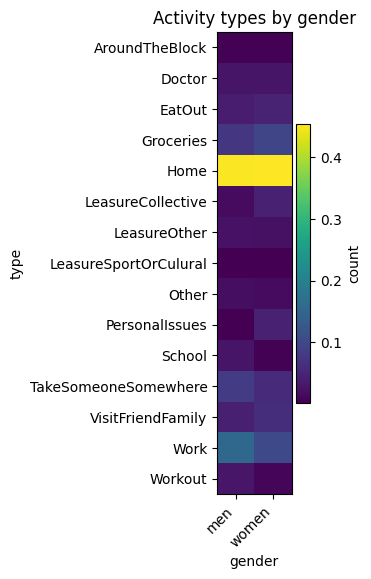

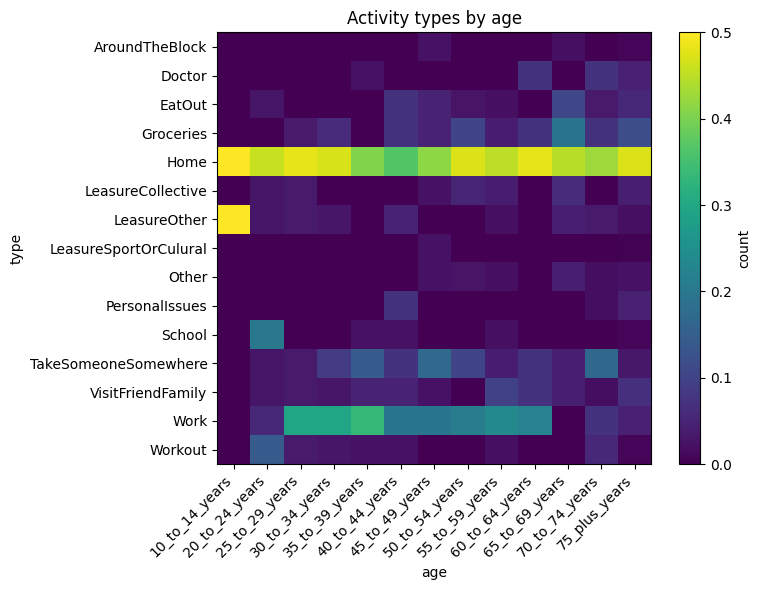

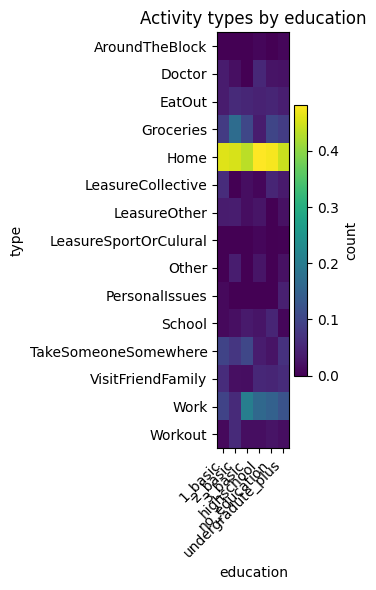

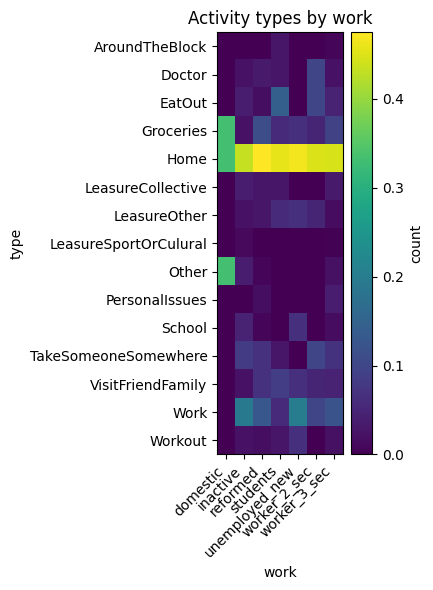

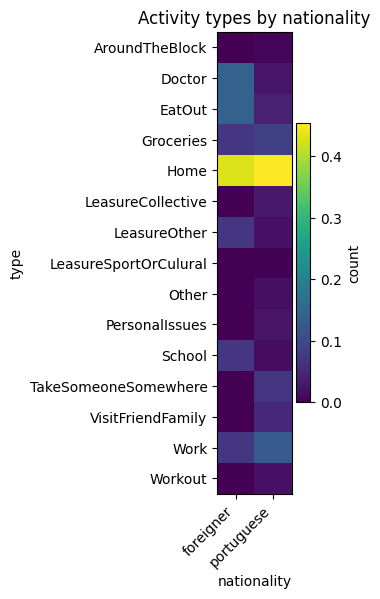

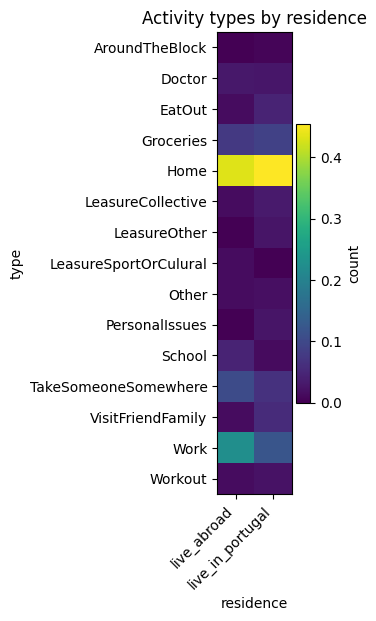

In [8]:
for att in atts[1:-1]:
    plot_grid(
        df_big,
        attribute=att,
        prefix="type_",
        title=f"Activity types by {att}",
        save=f"plots/{att}_type.png"
    )
